<a href="https://colab.research.google.com/github/andrewyzhuang/mae271D/blob/Janet_Ann_Weird_Existing_Code/Test_2_LPMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0 cost: 222.4505685442, Safe set size: 101
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.00141823  0.00013   ]
[-0.0014182

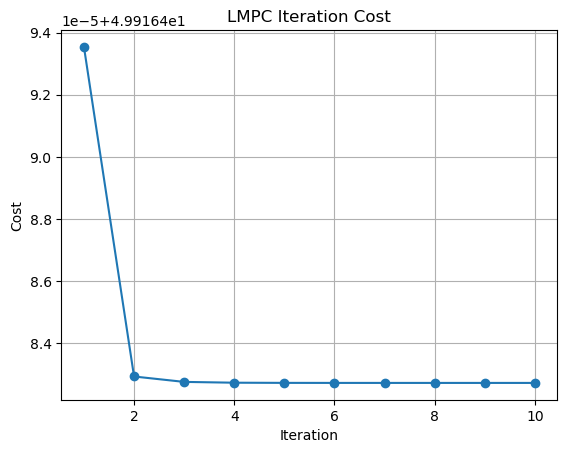

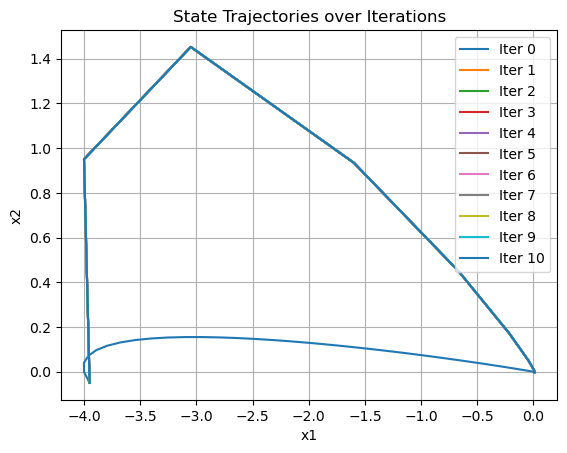

In [ ]:
import numpy as np
import cvxpy as cp
import casadi as ca
import matplotlib.pyplot as plt

# LMPC for Constrained LQR in Python (Single Script Version)
# System parameters
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.eye(2)
R = np.eye(1)

x_min = np.array([-4, -4])
x_max = np.array([4, 4])
u_min = np.array([-1])
u_max = np.array([1])

x0 = np.array([-3.95, -0.05])
xF = np.zeros(2)
N = 4
max_iters = 10
tol = 1e-4
# Function to compute initial feasible trajectory using a naive controller
def initial_trajectory(A, B, Q, R, x0, xF, u_min, u_max, tol, max_steps = 100):
    x_traj = [x0]
    u_traj = []
    x = x0.copy()
    for _ in range(max_steps):
        # Weak, inefficient control: slow damping of velocity
        u = np.clip(-0.2 * x[1] - 0.01 * x[0], u_min, u_max)
        x = A @ x + B @ u
        x_traj.append(x.copy())
        u_traj.append(np.array([u]))
        if np.linalg.norm(x - xF) < tol:
            break
    return np.array(x_traj), np.array(u_traj)

# Compute cost-to-go for each point in trajectory
def compute_cost_to_go(x_traj, u_traj, Q, R):
    costs = []
    for t in range(len(x_traj)):
      cost = 0.0
      # Iterate over the future trajectory from the current point t
      for k in range(t, len(x_traj) - 1):
        x = x_traj[k]
        u = u_traj[k]
        cost += (x.T @ Q @ x).item() + (u.T @ R @ u).item()

      # Add terminal cost from the last state
      if len(x_traj) > 0: # Check if trajectory is not empty
        cost += (x_traj[-1].T @ Q @ x_traj[-1]).item()

      costs.append(cost)
    return np.array(costs)

# LMPC solver with soft terminal cost

def solve_lmpc_casadi(A, B, Q, R, N, x0, ss_x, ss_cost, x_min, x_max, u_min, u_max):
    n = A.shape[0]
    m = B.shape[1]

    # Define optimization variables
    x = ca.MX.sym('x', n, N+1)
    u = ca.MX.sym('u', m, N)

    cost = 0
    g = []
    lbg = []
    ubg = []

    # Build the cost and constraints
    for k in range(N):
        # Stage cost
        cost += ca.mtimes([x[:, k].T, Q, x[:, k]]) + ca.mtimes([u[:, k].T, R, u[:, k]])

        # Dynamics constraint: x_{k+1} = A*x_k + B*u_k
        x_next = ca.mtimes(A, x[:, k]) + ca.mtimes(B, u[:, k])
        g.append(x[:, k+1] - x_next)
        lbg += [0.0] * n
        ubg += [0.0] * n

        # State constraints: x_min <= x_k <= x_max
        g.append(x[:, k] - x_min)
        lbg += [0.0] * n
        ubg += [ca.inf] * n

        g.append(x_max - x[:, k])
        lbg += [0.0] * n
        ubg += [ca.inf] * n

        # Input constraints: u_min <= u_k <= u_max
        g.append(u[:, k] - u_min)
        lbg += [0.0] * m
        ubg += [ca.inf] * m

        g.append(u_max - u[:, k])
        lbg += [0.0] * m
        ubg += [ca.inf] * m
 
    # Terminal state constraints: x_min <= x_N <= x_max
    g.append(x[:, N] - x_min)
    lbg += [0.0] * n
    ubg += [ca.inf] * n

    g.append(x_max - x[:, N])
    lbg += [0.0] * n
    ubg += [ca.inf] * n

    # Terminal cost from sampled safe set
    if len(ss_x) > 0:
        min_cost_idx = np.argmin(ss_cost)
        terminal_ref = ss_x[min_cost_idx]
        cost += ca.sumsqr(x[:, N] - terminal_ref)

    # Initial condition: x0
    g.append(x[:, 0] - x0)
    lbg += [0.0] * n
    ubg += [0.0] * n

    # Concatenate constraints and decision variables
    g = ca.vertcat(*g)
    vars = ca.vertcat(ca.vec(x), ca.vec(u))

    # Set up the NLP
    nlp = {'x': vars, 'f': cost, 'g': g}
    opts = {'ipopt.print_level': 0, 'print_time': 0}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    # Initial guess
    x_init = np.tile(x0.reshape(-1, 1), (1, N+1))
    u_init = np.zeros((m, N))
    vars_init = np.concatenate([x_init.flatten(), u_init.flatten()])

    # Solve
    sol = solver(x0=vars_init, lbg=lbg, ubg=ubg)
    sol_vars = sol['x'].full().flatten()

    # Extract u0 from solution
    x_flat_size = n * (N + 1)
    u_flat = sol_vars[x_flat_size:]
    u_opt = u_flat[:m]  # first control input

    return u_opt

# Run LMPC loop
ss_x = []
ss_cost = []

# Initial trajectory
x_traj, u_traj = initial_trajectory(A, B, Q, R, x0, xF, u_min, u_max, tol)
ss_x.extend(x_traj)
ss_cost.extend(compute_cost_to_go(x_traj, u_traj, Q, R))
init_cost = sum(x.T @ Q @ x + u.T @ R @ u for x, u in zip(x_traj[:-1], u_traj)) + x_traj[-1].T @ Q @ x_traj[-1]
init_x_traj = x_traj.copy()
print(f"Iteration {0} cost: {init_cost.item():.10f}, Safe set size: {len(ss_x)}")

all_costs = []
all_trajectories = []

for j in range(max_iters):
    x = x0.copy()
    traj_x = [x]
    traj_u = []

    for t in range(100):
        # u = solve_lmpc(A, B, Q, R, N, x, ss_x, ss_cost, x_min, x_max, u_min, u_max)
        u = solve_lmpc_casadi(A, B, Q, R, N, x, ss_x, ss_cost, x_min, x_max, u_min, u_max)

        if u is None:
            print(f"Infeasible at iter {j+1}, step {t}")
            break
        x = A @ x + B @ u
        traj_x.append(x.copy())
        traj_u.append(u.copy())
        if np.linalg.norm(x - xF) < tol:
            break

    x_traj = np.array(traj_x)
    u_traj = np.array(traj_u)
    ss_x.extend(x_traj)
    ss_cost.extend(compute_cost_to_go(x_traj, u_traj, Q, R))

    cost = sum(x.T @ Q @ x + u.T @ R @ u for x, u in zip(x_traj[:-1], u_traj)) + x_traj[-1].T @ Q @ x_traj[-1]
    all_costs.append(cost)
    all_trajectories.append(x_traj)
    print(f"Iteration {j+1} cost: {cost:.10f}, Safe set size: {len(ss_x)}")

print(all_costs)
# Plot cost per iteration
plt.figure()
ind = np.arange(1, j + 2)
plt.plot(ind, all_costs, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('LMPC Iteration Cost')
plt.grid(True)
plt.show()

# Plot trajectories
plt.figure()
x_plot = np.array(init_x_traj)
plt.plot(x_plot[:, 0], x_plot[:, 1], label=f"Iter {0}")
for j, x_traj in enumerate(all_trajectories):
    x_plot = np.array(x_traj)
    plt.plot(x_plot[:, 0], x_plot[:, 1], label=f"Iter {j+1}")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('State Trajectories over Iterations')
plt.legend()
plt.grid(True)
plt.show()
